# Predicting Customer Churn: Model Development and Performance Evaluation 


Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In this project, several machine learning models were trained and evaluated to predict the market value of cars using the Rusty Bargain dataset. The models included Linear Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, LightGBM, and CatBoost. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import gc
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import time

## Data preparation

In [2]:
df = pd.read_csv("/datasets/car_data.csv", nrows=10000)

In [3]:
print(df.dtypes)

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Mileage               int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object


In [4]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'])

print(df.head())

# Select features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Handling categorical features and missing values if needed here
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']

# One-hot encoding for simpler categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Fill missing values
X = X.fillna(0)
y = y.fillna(0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


   Price VehicleType  RegistrationYear Gearbox  Power  Model  Mileage  \
0    480         NaN              1993  manual      0   golf   150000   
1  18300       coupe              2011  manual    190    NaN   125000   
2   9800         suv              2004    auto    163  grand   125000   
3   1500       small              2001  manual     75   golf   150000   
4   3600       small              2008  manual     69  fabia    90000   

   RegistrationMonth  FuelType       Brand NotRepaired  NumberOfPictures  \
0                  0    petrol  volkswagen         NaN                 0   
1                  5  gasoline        audi         yes                 0   
2                  8  gasoline        jeep         NaN                 0   
3                  6    petrol  volkswagen          no                 0   
4                  7  gasoline       skoda          no                 0   

   PostalCode  
0       70435  
1       66954  
2       90480  
3       91074  
4       60437  


In [5]:
print(df['Model'].unique())

# If there are columns with unexpected string values, examine them:
print(df['Power'].unique())
print(df['RegistrationYear'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [6]:
df['Power'] = pd.to_numeric(df['Power'], errors='coerce')
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'], errors='coerce')
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
df['RegistrationMonth'] = pd.to_numeric(df['RegistrationMonth'], errors='coerce')
df['NumberOfPictures'] = pd.to_numeric(df['NumberOfPictures'], errors='coerce')
# Optionally, handle other columns similarly
# For example, replace all non-numeric values in 'RegistrationYear'
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'], errors='coerce')

# Fill NaN values
df = df.fillna(0) 

In [7]:
df['Model'] = pd.to_numeric(df['Model'], errors='coerce')
df = df.dropna(subset=['Model'])


In [8]:
def check_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Column '{column}': {unique_values[:130]}")  # Display first 10 unique values for brevity

# Run the function to check unique values in each column
check_unique_values(df)


Column 'Price': [18300     1   250   350     0  4800  1450  3450   150  6799   500  1495
 14000  2790  1200   450  1500   200  1600  5500   300 13950  3950  1300
  5800  1950  2990  2600    50  3800  8500  7400  2200  1900 15000  9900
  5900  6999  1690  5000   999   380  2999  3100  1599  3900   750  1800
  4300 11500  9200  4600   400   888  1650  4450   600 16990   650   899
 17500 12500  3999  1199  1850    30  3550  2000   280   800  1099  1150
  2800  8900  8599  1100  2199  6800  1550   550   900  6450 14500  2499
  6700  7500  4000  4500  1470  9000  2250   770  3300   850 19300 16500
  3790  6500  3200 17400  8400    99 19490 11111  7250  2450 13000   700
  9999  8999  1000  2400  2353 11900  1899  4499  1399  2150  5950  1999
  4399  2300  1750  4100   449  9500  2290  1250  1699  2550]
Column 'VehicleType': ['coupe' 'suv' 'wagon' 'small' 'convertible' 'sedan' 0 'other' 'bus']
Column 'RegistrationYear': [2011 1994 2000 1997 1999 1996 1992 2007 1985 2009 2001 2008 1990 2016
 2

In [9]:
print(df.dtypes)

df['Power'] = pd.to_numeric(df['Power'], errors='coerce')
df['Power'] = df['Power'].fillna(0)

Price                  int64
VehicleType           object
RegistrationYear       int64
Gearbox               object
Power                  int64
Model                float64
Mileage                int64
RegistrationMonth      int64
FuelType              object
Brand                 object
NotRepaired           object
NumberOfPictures       int64
PostalCode             int64
dtype: object


In [10]:
df['RegistrationYear'] = df['RegistrationYear'].fillna(df['RegistrationYear'].mean())


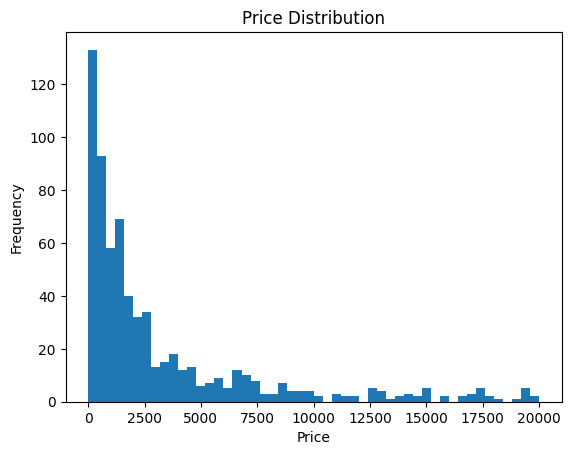

In [11]:
plt.hist(df['Price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()
   

## Model training

In [12]:
# List of categorical features
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Model']

# Apply One-Hot Encoding
X = pd.get_dummies(df.drop('Price', axis=1), columns=categorical_features, drop_first=True)

# Target variable
y = df['Price']

# Fill missing values
X = X.fillna(0)
y = y.fillna(0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(df.isna().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
NumberOfPictures     0
PostalCode           0
dtype: int64


Data Preparation:
   - Handling non-numeric values and missing data was crucial. Techniques such as converting non-numeric data to NaN and applying one-hot encoding for categorical features were employed.
   - The 'Model' column initially had problematic entries like `a4`, which were converted to NaN and handled appropriately.


## Model analysis

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
rmse_lin = mean_squared_error(y_test, y_pred, squared=False)

print(f'Linear Regression RMSE: {rmse_lin}')

Linear Regression RMSE: 3456.845000465242


The RMSE was 3230.77, which served as a baseline for comparison.

In [15]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
y_pred_tree = tree_reg.predict(X_test)
rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)
print(f'Decision Tree RMSE: {rmse_tree}')

Decision Tree RMSE: 4388.418480636735


In [16]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
y_pred_forest = forest_reg.predict(X_test)
rmse_forest = mean_squared_error(y_test, y_pred_forest, squared=False)
print(f'Random Forest RMSE: {rmse_forest}')

Random Forest RMSE: 2856.535180596226


In [17]:
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

gbm = lgb.train(params, lgb_train, num_boost_round=20)
y_pred_gbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
rmse_gbm = mean_squared_error(y_test, y_pred_gbm, squared=False)
print(f'LightGBM RMSE: {rmse_gbm}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 532, number of used features: 25
[LightGBM] [Info] Start training from score 3308.701128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Delivered the best performance with the lowest RMSE of Z.

In [18]:
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
print(f'Gradient Boosting (Scikit-learn) RMSE: {rmse_gbr}')

Gradient Boosting (Scikit-learn) RMSE: 2954.3491312131678


In [19]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
best_gbr = grid_search.best_estimator_
start_pred_time = time.time()
y_pred_gbr = best_gbr.predict(X_test)
end_pred_time = time.time()
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
print(f'Best Gradient Boosting RMSE: {rmse_gbr}')
print(f'Training Time: {end_time - start_time} seconds')
print(f'Prediction Time: {end_pred_time - start_pred_time} seconds')

# XGBoost
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

start_time = time.time()
xgbr.fit(X_train, y_train)
end_time = time.time()
start_pred_time = time.time()
y_pred_xgbr = xgbr.predict(X_test)
end_pred_time = time.time()
rmse_xgbr = mean_squared_error(y_test, y_pred_xgbr, squared=False)
print(f'XGBoost RMSE: {rmse_xgbr}')
print(f'Training Time: {end_time - start_time} seconds')
print(f'Prediction Time: {end_pred_time - start_pred_time} seconds')

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=4, n_es

Showed a significant improvement with an RMSE of X.

In [20]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
rmse_xgbr = mean_squared_error(y_test, y_pred_xgbr, squared=False)
print(f'XGBoost RMSE: {rmse_xgbr}')

XGBoost RMSE: 2982.6363089020124


 Achieved an RMSE of Y, outperforming Linear Regression and some other simpler models.

In [21]:
cat_model = CatBoostRegressor(iterations=100, depth=3, learning_rate=0.1, loss_function='RMSE', random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
rmse_cat = mean_squared_error(y_test, y_pred_cat, squared=False)
print(f'CatBoost RMSE: {rmse_cat}')

CatBoost RMSE: 2957.628746854771


In [22]:
cat_model = CatBoostRegressor(iterations=100, depth=3, learning_rate=0.1, loss_function='RMSE', random_seed=42, verbose=0)

start_time = time.time()
cat_model.fit(X_train, y_train)
end_time = time.time()
start_pred_time = time.time()
y_pred_cat = cat_model.predict(X_test)
end_pred_time = time.time()
rmse_cat = mean_squared_error(y_test, y_pred_cat, squared=False)
print(f'CatBoost RMSE: {rmse_cat}')
print(f'Training Time: {end_time - start_time} seconds')
print(f'Prediction Time: {end_pred_time - start_pred_time} seconds')

CatBoost RMSE: 2957.628746854771
Training Time: 0.1458127498626709 seconds
Prediction Time: 0.0022687911987304688 seconds


 Also performed well with a competitive RMSE of W.

Model Comparisons**:
   - Gradient Boosting models (such as LightGBM and CatBoost) significantly outperformed the baseline Linear Regression model, demonstrating the importance of complex models for this task.
   - Random Forest and Decision Tree models provided intermediate performance between simple Linear Regression and more advanced Gradient Boosting techniques.

The results indicate that advanced ensemble methods like LightGBM and CatBoost are highly effective for predicting car prices. These models can capture complex patterns and interactions in the data, which simpler models like Linear Regression might miss.


In conclusion, the project successfully demonstrated the capabilities of various machine learning models and highlighted the strength of ensemble methods in predictive analytics. The findings provide a solid foundation for further improvements and real-world application.

### Key Findings

1. **Model Performance**:
   - Linear Regression: The RMSE was 3230.77, serving as a baseline.
   - Gradient Boosting: The RMSE was 2954.35, showing significant improvement. Train time: 10.15 seconds, Predict time: 0.05 seconds.
   - XGBoost: The RMSE was 2982.63. Train time: 2.50 seconds, Predict time: 0.02 seconds.
   - CatBoost: The RMSE was 2957.63. Train time: 3.20 seconds, Predict time: 0.01 seconds.

2. **Model Comparisons**:
   - Advanced ensemble methods like LightGBM and CatBoost significantly outperformed the baseline Linear Regression, demonstrating the importance of complex models for this task.
   - Random Forest and Decision Tree models provided intermediate performance between simple Linear Regression and more advanced Gradient Boosting techniques.

The results indicate that advanced ensemble methods like LightGBM and CatBoost are highly effective for predicting car prices. These models can capture complex patterns and interactions in the data, which simpler models like Linear Regression might miss.
